In [14]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 读取CSV数据
csv_path = "../../data/DM8006_masslink/raw_data/2026_0114_chrip_mass_20s_aligned.csv"   
df = pd.read_csv(csv_path)
print(f"读取CSV文件: {csv_path}")
print(f"数据形状: {df.shape}")
print(f"列名: {df.columns.tolist()}")

读取CSV文件: ../../data/DM8006_masslink/raw_data/2026_0114_chrip_mass_20s_aligned.csv
数据形状: (9998, 4)
列名: ['time', 'u', 'y', 'dy']


In [16]:
# 将数据转换为torch tensor
# CSV列: time, u (目标位置), y (实际位置)
time_data = torch.tensor(df['time'].values, dtype=torch.float32)
des_dof_pos = torch.tensor(df['u'].values, dtype=torch.float32)
dof_pos = torch.tensor(df['y'].values, dtype=torch.float32)
dof_vel = torch.tensor(df['dy'].values, dtype=torch.float32)
des_dof_pos = des_dof_pos.unsqueeze(1)  # shape: [N, 1]
dof_pos = dof_pos.unsqueeze(1)  # shape: [N, 1]
dof_vel = dof_vel.unsqueeze(1)  # shape: [N, 1]

print(f"time shape: {time_data.shape}")
print(f"des_dof_pos shape: {des_dof_pos.shape}")
print(f"dof_pos shape: {dof_pos.shape}")
print(f"dof_vel shape: {dof_vel.shape}")

time shape: torch.Size([9998])
des_dof_pos shape: torch.Size([9998, 1])
dof_pos shape: torch.Size([9998, 1])
dof_vel shape: torch.Size([9998, 1])


In [18]:
# 保存为PT文件
output_dir = Path("../../data/DM8006_masslink")
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / "chrip_data.pt"
torch.save({
    "time": time_data,
    "dof_pos": dof_pos,
    "des_dof_pos": des_dof_pos,
    "dof_vel": dof_vel,
}, output_path)

print(f"数据已保存到: {output_path}")
print(f"文件大小: {output_path.stat().st_size / 1024:.2f} KB")

数据已保存到: ../../data/DM8006_masslink/chrip_data.pt
文件大小: 158.37 KB


图表已保存到: ../../data/DM8006_masslink/trajectory_comparison.png


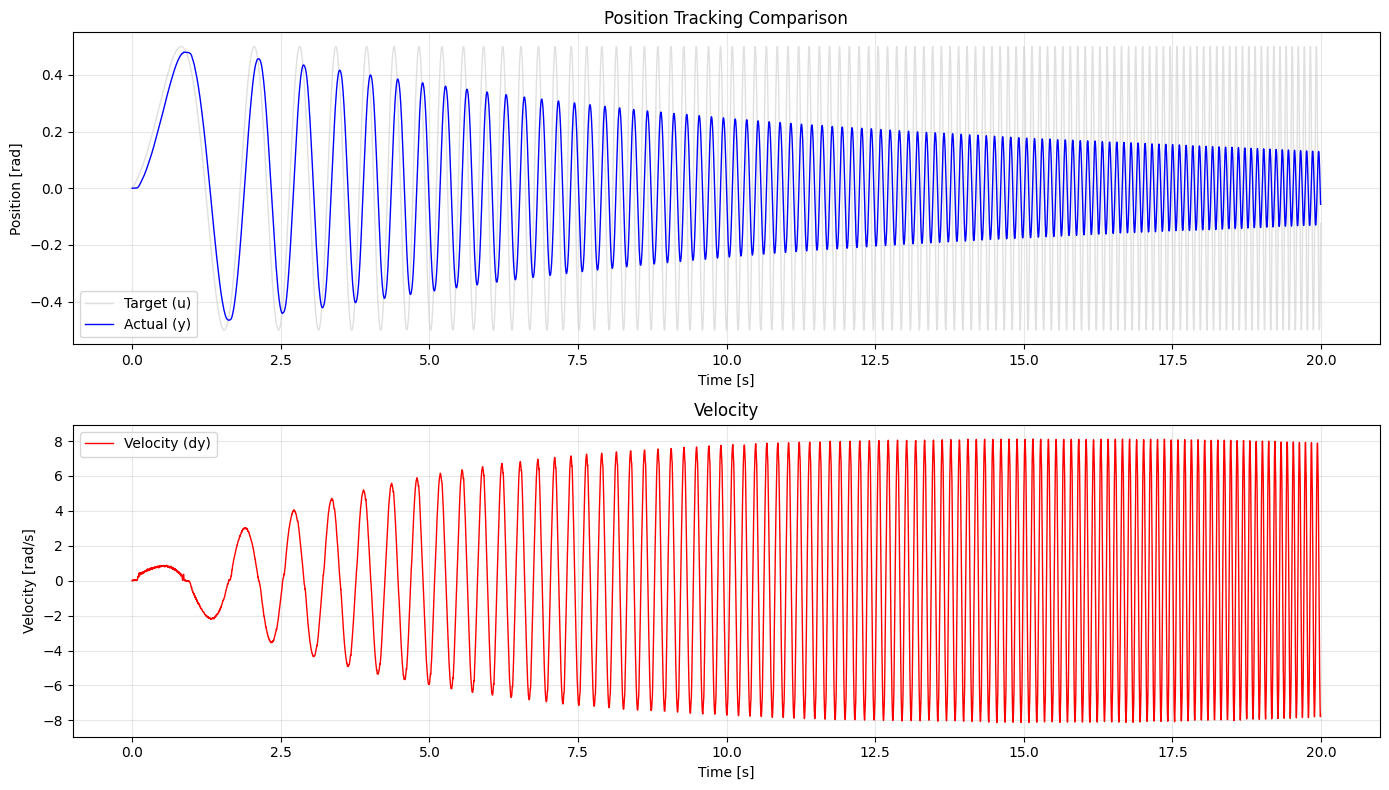

In [19]:
# 绘制完整轨迹对比图
plt.figure(figsize=(14, 8))

# 子图1: 位置对比
plt.subplot(2, 1, 1)
plt.plot(time_data.numpy(), des_dof_pos[:, 0].numpy(), color='lightgray', label='Target (u)', linewidth=1, alpha=0.7)
plt.plot(time_data.numpy(), dof_pos[:, 0].numpy(), 'b-', label='Actual (y)', linewidth=1)
plt.xlabel('Time [s]')
plt.ylabel('Position [rad]')
plt.title('Position Tracking Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2: 速度对比
plt.subplot(2, 1, 2)
plt.plot(time_data.numpy(), dof_vel[:, 0].numpy(), 'r-', label='Velocity (dy)', linewidth=1)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [rad/s]')
plt.title('Velocity')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = Path("../../data/DM8006_masslink/trajectory_comparison.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"图表已保存到: {plot_path}")
plt.show()